In [1]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [2]:
s = '11'

In [3]:
# Creating registers
# qubits for querying the oracle and finding the hidden period s
qr = QuantumRegister(2*len(str(s)))
# classical registers for recording the measurement on qr
cr = ClassicalRegister(2*len(str(s)))

simonCircuit = QuantumCircuit(qr, cr)
barriers = True

# Apply Hadamard gates before querying the oracle
for i in range(len(str(s))):
    simonCircuit.h(qr[i])    

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply the inner-product oracle 
if s == '11':
## 2-qubit oracle for s = 11
    simonCircuit.cx(qr[0], qr[len(str(s)) + 0])
    simonCircuit.cx(qr[0], qr[len(str(s)) + 1])
    simonCircuit.cx(qr[1], qr[len(str(s)) + 0])
    simonCircuit.cx(qr[1], qr[len(str(s)) + 1])  
elif s == '110':
## 3-qubit oracle for s = 110
    simonCircuit.cx(qr[2], qr[4])  
    simonCircuit.x(qr[3])  
    simonCircuit.cx(qr[2], qr[3])  
    simonCircuit.ccx(qr[0], qr[1], qr[3])  
    simonCircuit.x(qr[0])  
    simonCircuit.x(qr[1])  
    simonCircuit.ccx(qr[0], qr[1], qr[3])  
    simonCircuit.x(qr[0])  
    simonCircuit.x(qr[1])  
    simonCircuit.x(qr[3])

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Measure ancilla qubits
for i in range(len(str(s)), 2*len(str(s))):
    simonCircuit.measure(qr[i], cr[i])

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Apply Hadamard gates to the input register
for i in range(len(str(s))):
    simonCircuit.h(qr[i])

# Apply barrier 
if barriers:
    simonCircuit.barrier()

# Measure input register
for i in range(len(str(s))):
    simonCircuit.measure(qr[i], cr[i])

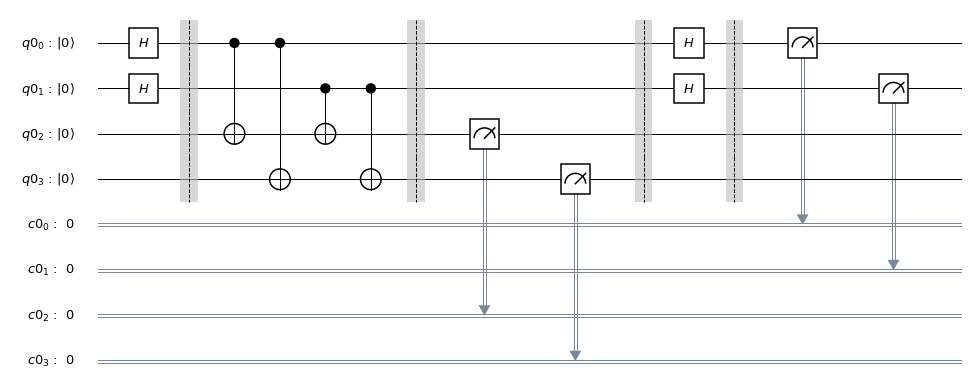

In [4]:
simonCircuit.draw(output='mpl')

In [5]:
IBMQ.load_accounts()
IBMQ.backends()
backend_lb = least_busy(IBMQ.backends(simulator=False))
print("Least busy backend: ", backend_lb)

Least busy backend:  ibmqx2


In [6]:
# run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

backend = backend_lb
shots = 1024
job_exp = execute(simonCircuit, backend=backend, shots=shots)

job_monitor(job_exp, interval = 2)

Job Status: job has successfully run


In [7]:
def sdotz(a, b):
    accum = 0
    for i in range(len(a)):
        accum += int(a[i]) * int(b[i])
    return (accum % 2)

In [8]:
# get the results from the computation
results = job_exp.result()
answer = results.get_counts(simonCircuit)
print(answer)

{'0000': 69, '1011': 48, '0101': 53, '0001': 122, '0100': 36, '1000': 30, '0010': 81, '1101': 90, '0110': 40, '1100': 56, '1110': 41, '1111': 109, '1001': 57, '0011': 99, '0111': 41, '1010': 52}


{'00': 191, '11': 297, '01': 322, '10': 214}


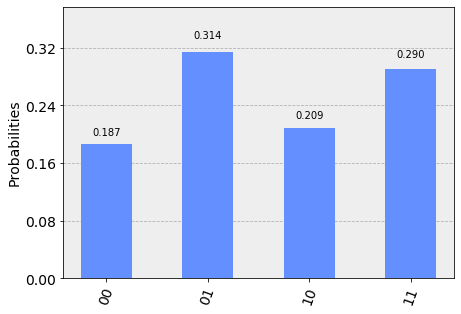

In [9]:
# categorize measurements by input register values
answer_plot = {}
for measresult in answer.keys():
    measresult_input = measresult[len(str(s)):]
    if measresult_input in answer_plot:
        answer_plot[measresult_input] += answer[measresult]
    else:
        answer_plot[measresult_input] = answer[measresult] 

# plot the categorized results
print( answer_plot )
plot_histogram(answer_plot)

In [10]:
# calculate the dot product of the most significant results
print('s, z, s.z (mod 2)')
for z_rev in answer_plot:
    if answer_plot[z_rev] >= 0.1*shots:
        z = z_rev[::-1]
        print( '{}, {}, {}.{}={}'.format(s, z, s,z,sdotz(s,z)) )

s, z, s.z (mod 2)
11, 00, 11.00=0
11, 11, 11.11=0
11, 10, 11.10=1
11, 01, 11.01=1
